<a href="https://colab.research.google.com/github/aashu-0/learn-pytorch/blob/main/04_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [2]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

###Get Data
- we're going to use a small subset of Food101 dataset
- Food101 dataset -> 1000 images of 101 different kinds of foods
- but we are going to only classify 3 foods(sushi, pizza, steak)

In [3]:
import requests
import zipfile
from pathlib import Path

# setup path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# download if, image folder doesn't exists
if image_path.is_dir():
  print(f"{image_path} directory already exists...skipping download")
else:
  print(f"{image_path} does not exists...creating one")
  image_path.mkdir(parents = True, exist_ok = True)

data/pizza_steak_sushi does not exists...creating one


In [4]:
# download zip file from daniel github

with open(data_path/ "pizza_steak_sushi.zip", 'wb') as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print('Downloading....the github zip file')
  f.write(request.content)

Downloading....the github zip file


In [5]:
# unzip the data
with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping the zip file')
  zip_ref.extractall(image_path)

Unzipping the zip file


### Data exploration and visualizaton

In [6]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [7]:
# setup train and testing paths

train_dir = image_path/'train'
test_dir = image_path/'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

###Visualize the image
- get all the image paths
- pick any random path
- get the image class name
- open the image using PIL library
- print some metadata of the image

Random image path : data/pizza_steak_sushi/train/pizza/2885050.jpg
Image_class: pizza
Image width: 512
Image height: 512


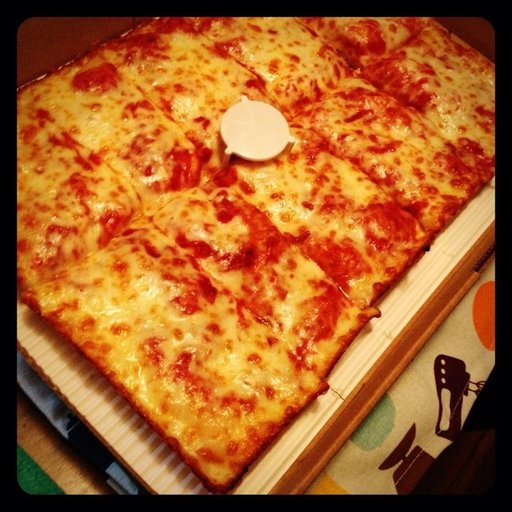

In [8]:
import random
from PIL import Image

random.seed(69)

# get all path in a list
image_path_list = list(image_path.glob('*/*/*.jpg'))  #glob -> to find files matching the specific pattern

# get a random image path
random_image_path = random.choice(image_path_list)


# get image_class
# image_class -> name of the directory where the image is stored
image_class = random_image_path.parent.stem
image_class
# parent -> 'data/pizza_steak_sushi/test/pizza'
# stem -> last directory i.e 'pizza'


# open image
img = Image.open(random_image_path)

# metadata
print(f'Random image path : {random_image_path}')
print(f'Image_class: {image_class}')
print(f'Image width: {img.width}')
print(f'Image height: {img.height}')
img

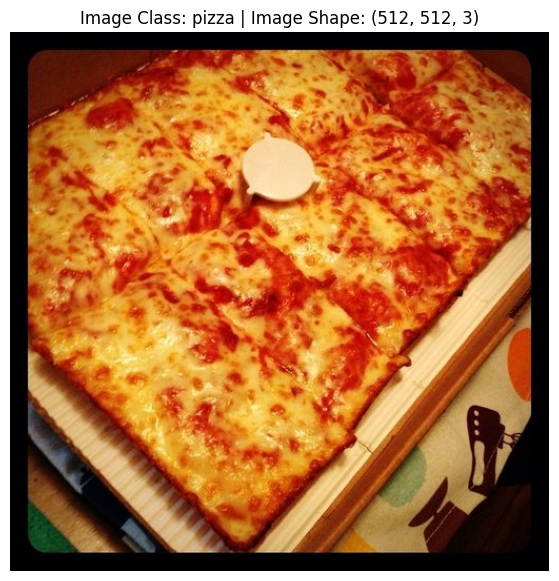

In [9]:
# __alter__
# visualizing using matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_to_arr = np.asarray(img)

# plot
plt.figure(figsize=(10,7))
plt.imshow(img_to_arr)
plt.title(f'Image Class: {image_class} | Image Shape: {img_to_arr.shape}')
plt.axis(False);

array([[[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       [[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       [[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       ...,

       [[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       [[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]],

       [[0, 0, 2],
        [0, 0, 2],
        [0, 0, 2],
        ...,
        [0, 0, 2],
        [0, 0, 2],
        [0, 0, 2]]], dtype=uint8)
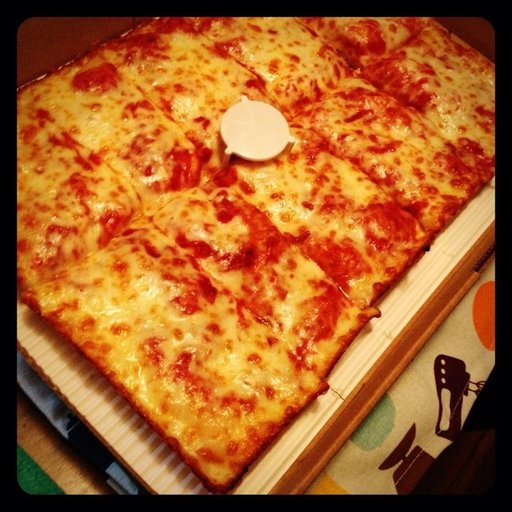

In [10]:
img_to_arr

###Transforming data
1. into tensors
2. dataset and dataloaders

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

####Transforming data with `torchvision.transforms`
- transforms -> helps to get the images ready to be used with a model(perform data augmentation)

In [12]:
# transforms.Compose class for composing several transforms together
data_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
data_transforms(img), data_transforms(img).shape

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0471,  ..., 0.0431, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0196,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0157,  ..., 0.0118, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0392,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0078, 0.0078],
          [0.0078, 0.0078, 0.0157,  ...,

- visualizing the transformed images

`plot_transformed_images` -> selects random images from image_path and loads/transforms and then plot the original vs transformed one

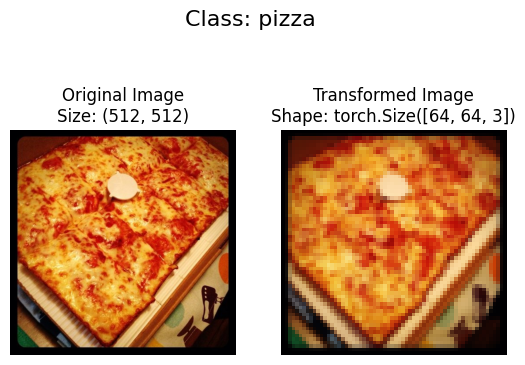

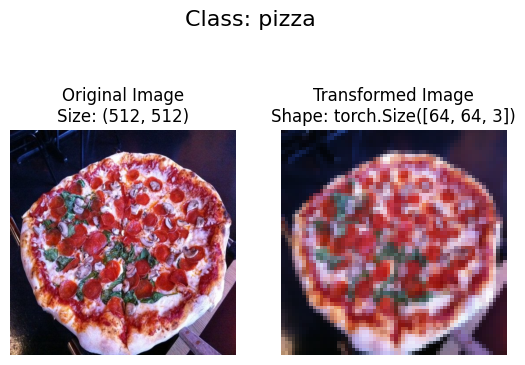

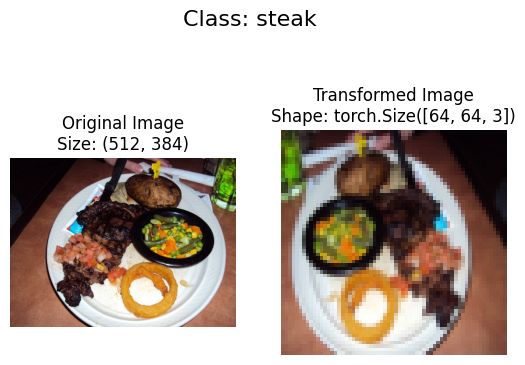

In [13]:
def plot_transformed_images(image_path: list, transform, n: int, seed = None):    # n-> no. of images
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_path, k =n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original Image\nSize: {f.size}')
      ax[0].axis(False)

      # transform and plot
      # here our transformed images have shape (3,64,64) i.e color channels are at 0 index
      # but matplotlib expects color channels to be at -1 index
      # so we need to permute(change the order)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed Image\nShape: {transformed_image.shape}')
      ax[1].axis(False)

      # adding a super title
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize= 16)


plot_transformed_images(image_path= image_path_list,
                        transform= data_transforms,
                        n=3,
                        seed = 69)

####Loading Image data using `ImageFolder`
- `torchvision.datasets.ImageFolder`

In [14]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform= data_transforms, #a transform for the data
                                  target_transform=None) #a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform= data_transforms)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# get class_names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# lengths of datasets
len(train_data), len(test_data)

(225, 75)

In [18]:
# visualizing the train_data
img, label = train_data[0]
print(f'Image Tensor: \n{img}')
print(f'Image shape: {img.shape}')
print(f'Image Datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Lable Datatype: {type(label)}')

Image Tensor: 
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Text(0.5, 1.0, 'pizza')

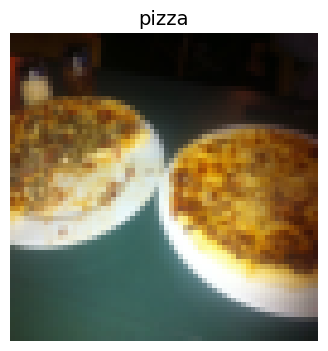

In [19]:
# reordering the dimension to make it compatible with matplotlib
img_permute = img.permute(1,2,0)
img_permute.shape

# plot the image
plt.figure(figsize=(4,4))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

####Turn our images into `Dataloader`
  * `Dataloader` -> to turn Datasets into iterables
advantages
-  to not run out of memory
- our model see data one batch at a time -> so efficient

  * `num_workers` -> how many cpu calls that is used to load the data
- the higher the better

In [20]:
import os
os.cpu_count()

2

In [21]:
# train and test datasets into DataLoader's

from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                               batch_size = BATCH_SIZE,
                               num_workers= 1,
                               shuffle = True
)
test_dataloader = DataLoader(test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False
)

In [22]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [23]:
img, label = next(iter(train_dataloader))

print(f'Image Shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'Label Shape: {label.shape}')

#let's visualize an sample
img_sample = img[0]

# making it shape compatiable to matplotlib
img_sample_modified = img_sample.squeeze().permute(1,2,0)
img_sample_modified.shape

Image Shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([32])


torch.Size([64, 64, 3])

Text(0.5, 1.0, 'steak')

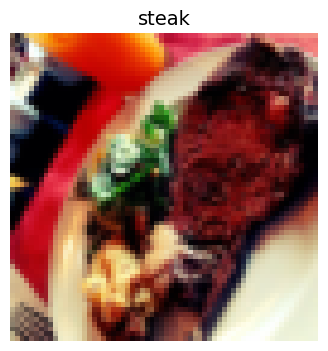

In [24]:
plt.figure(figsize=(4,4))
plt.imshow(img_sample_modified)
plt.axis(False)
plt.title(class_names[label[0]], fontsize=14)

### Loading image data with a custom dataset

  i.e creating our own `ImageFolder` class
* we want to be able to:
 1. load images from file
 2. to get class names
 3. to get classes as dict from the dataset

* Pros:
1. create `Dataset` out of almost anything
2. not limited to pre-bulit fun

* Cons:
1. it will not always work...so lots of debugging and testing
2. have to write more code -> more errors :P

In [25]:
# []
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# what we want to code a helper function to get this result

# an instance of torchvision.data.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [27]:
# setup path for target directory
target_directory = train_dir
print(f'Target Directory: {target_directory}')

Target Directory: data/pizza_steak_sushi/train


In [28]:
l1 = list(os.scandir(target_directory))
l1[0].name

'pizza'

In [29]:
# get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [30]:
# let's define a function to do this

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:

  # get the class names by scanning the directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # raise error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}" )

  # create a dict of index labels
  class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [31]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

####Create a custom `Dataset` to replicate `ImageFolder`
- To create our own custon dataset, we want to:
  1. subclass `torch.utils.data.Dataset`
  2. init our subclass with a target directory and transform
  3. create several attributes (attributes depend on type of data we are dealing with)
    * paths
    * transform
    * classes
    * class_to_idx - dict
  4. create a fun to `load_images()`
  5. overwrite `__len()__` method to return length of dataset
  6. overwrite `__getitem()__` method to return a sample when an index is passed

In [32]:
# img, label = train_data[0]
# img, label

# __getitem__() will replicate this

In [33]:
# write a custom dataset class

from torch.utils.data import Dataset

#subclass
class ImageFolderCustom(Dataset):
  # initialize
  def __init__(self, targ_dir: str, transform= None) -> None:

    #class attributes
    self.path = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # transform
    self.transform = transform
    # classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # func to load images
  def load_image(self, index:int) -> Image.Image:
    "returns an images using PIL Image class via a path"
    image_path = self.path[index]
    return Image.open(image_path)

  # overwrite __len__() [OPTIONAL]
  def __len__(self) -> int:
    "returns total no. of samples"
    return len(self.path)

  # overwrite __getitem__() [REQUIRED]
  def __getitem__(self, index:int) -> Tuple[torch.tensor, int]:
    "return a particular sample, data and label (X,y)"
    img = self.load_image(index)
    class_name = self.path[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [34]:
# Creating a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [35]:
# test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7840d22b71c0>,
 <__main__.ImageFolderCustom at 0x7840d22b4610>)

In [36]:
# checking equality b/w our ImageFolder and our ImageFolderCustom

print(len(train_data)==len(train_data_custom))
print(train_data.classes==train_data_custom.classes)
print(train_data.class_to_idx== train_data_custom.class_to_idx)

True
True
True


### Visualize random image using `ImageFolderCustom`class
* create a func to display random images

In [37]:
#random.sample(range(len(train_data_custom)), k=10)

In [38]:
#train_data_custom[50]

In [39]:
def display_random_images(dataset: torch.utils.data.dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool =True,
                          seed: int = None):
  # adjust display if n is to high
  if n >10:
    n = 10
    display_shape = False
    print(f"for preventing display getting out of hand , n shouldn't be larger than 10")

  if seed:
    random.seed(seed)

  # get random sample index
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16,8))

  # loop through the indexes and plot
  for i, targ_sample in enumerate(random_samples_idx):
    targ_img, targ_label = dataset[targ_sample]

    # adjust dimension to make matplotlib happy :)
    targ_img_adjust = targ_img.permute(1,2,0)

    #plot
    plt.subplot(1, n, i+1)
    plt.imshow(targ_img_adjust)
    plt.axis(False)
    if classes:
      title = f'Class: {classes[targ_label]}'
      if display_shape:
        title = title + f"\nshape: {targ_img_adjust.shape}"
    plt.title(title)

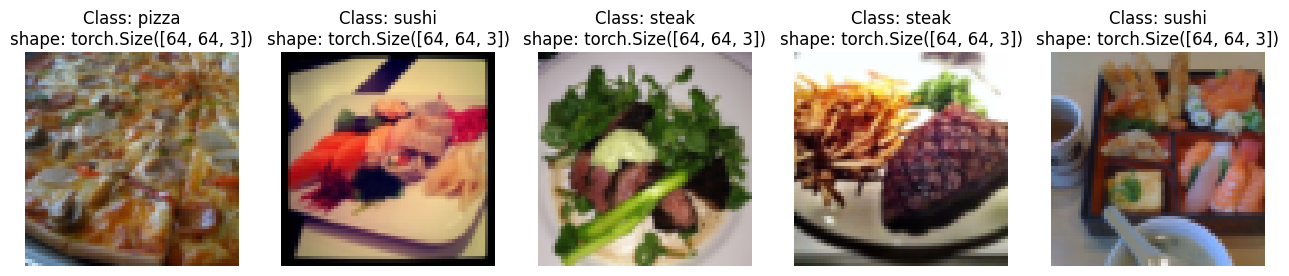

In [40]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed= None)

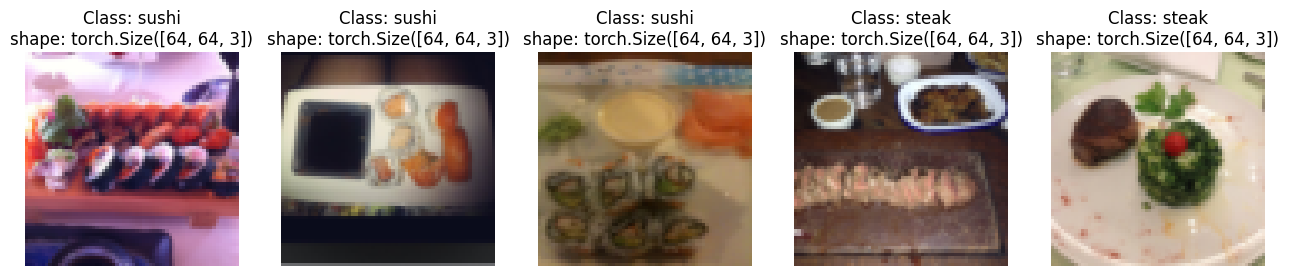

In [41]:
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed= None)

### Turn our custom datasets into DataLoader

In [42]:
from torch.utils.data import DataLoader

BATCH_SIZE =32 # a good batch size is a multiple of 8(Why??) --> efficient

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=1,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=1,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7840d1ab3910>,
 <torch.utils.data.dataloader.DataLoader at 0x7840d1ab36a0>)

In [43]:
# get an image and label
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### Other forms of transforms -> (Augmentation of Data)
[pytorch docs example](https://pytorch.org/vision/0.20/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py)

- why data augmentation
 * to artificially increase the diversity of a dataset

- let's see one partcular type of augmentation used to train Pytorch model at SOTA levels => `TrivialAugmentWide`

In [44]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size= (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    #num_magnitude_bins, how intense u want augmentation to happen (a no. from 0 to 31)
    #transforms.ElasticTransform(alpha=100.0),
    #transforms.ColorJitter(contrast=60.0, brightness=3.0),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size= (224,224)),
    transforms.ToTensor()
])

In [45]:
image_path_list[:6]

[PosixPath('data/pizza_steak_sushi/train/pizza/3018077.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2428085.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3338774.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/12301.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2811032.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/68684.jpg')]

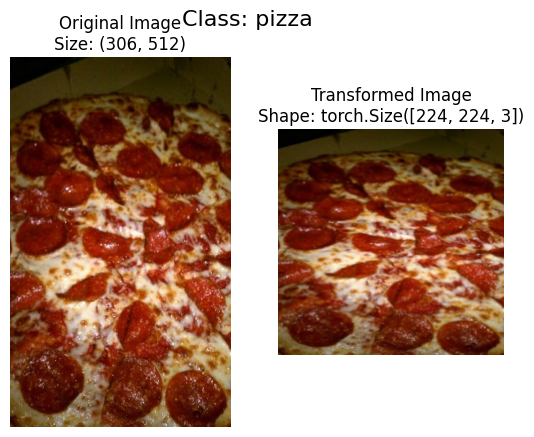

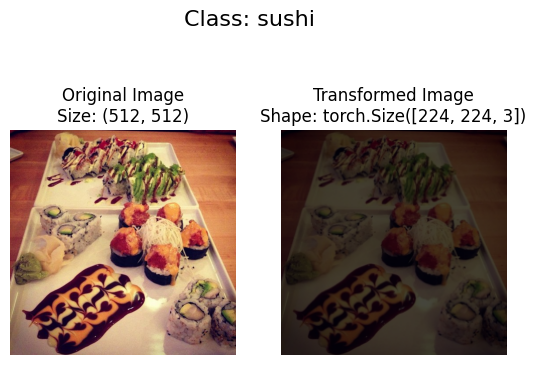

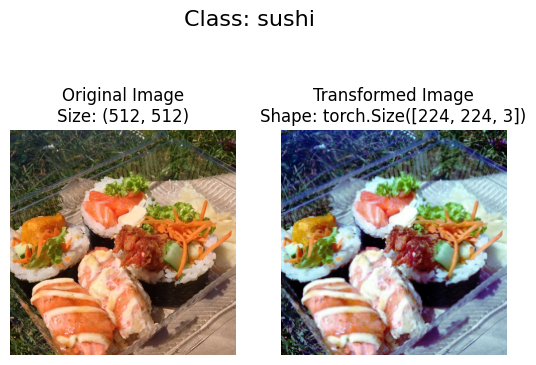

In [46]:
# plot some random transformed images
plot_transformed_images(
    image_path=image_path_list,
    transform=train_transform,
    n=3,
    seed = None
)

### Model 0: TinyVGG(from CNN Explainer) without data augmentation


#### Creating transforms and loading data

In [47]:
# simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size= (64,64)),
    transforms.ToTensor()
])

# load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root= train_dir,
                                         transform= simple_transform)
test_data_simple = datasets.ImageFolder(root= test_dir,
                                         transform= simple_transform)

# datasets into dataloaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple= DataLoader(dataset=train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle= False)


#### TinyVGG Model Architecture

* input -> `[cnn layer -> activation -> pooling]` -> output
* `[..]` -> called as a block and it can be repeated multiple times

layers to be used:

- `nn.Con2d()` , `nn.MaxPool2d()`
-
`nn.Flatten()` -> to convert outputs of our conv blocks into feature vector which then passed to a linear layer

In [48]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int)-> None:
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # by default equal to kernel_size
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # by default equal to kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(#in_features=hidden_units,  # can be determined using formulas
                  in_features=hidden_units*13*13, # shape fixed
                  out_features=output_shape)
    )

  # to find in_features, we can do a forward pass
  def forward(self, x):
    x = self.conv_block1(x)
    #print(x.shape)
    x = self.conv_block2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
    # using operation fusion we can do all above in single step
    # why?? improves gpu performance to compute
    # return self.classifier(self.conv_block2(self.conv_block1(x)))

In [49]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, # no. of color channels
                  hidden_units=10, # form TinyVGG
                  output_shape= len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

#### Do a forward pass to check for shapes

how to find the correct `in_features` in the `Linear` layer
- pass some dummy data to the model -> do a forward pass

In [50]:
# get a single batch
img_batch, label_batch = next(iter(train_dataloader_simple))
img_batch, label_batch = img_batch.to(device), label_batch.to(device)
img_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [51]:
# do forward pass
model_0(img_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

:**RuntimeError**: mat1 and mat2 shapes cannot be multiplied (32x1690 and 10x3)
here the error is expected
- now we see the shape of output of `conv_block_2` layer is `[32, 10, 13, 13]`
- this should be input to our classifer layer
```
10*13*13 = 1690
```


#### Use `torchinfo` to get model info and shapes

In [52]:
!pip install torchinfo

In [53]:
from torchinfo import summary
summary(model=model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Train and Test Functions

In [54]:
# train func
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: device):

  # to train mode
  model.train()

  train_loss, train_acc = 0,0

  # loop through each batch
  for batch, (X,y) in enumerate(dataloader):
    #.to(device)
    X, y = X.to(device), y.to(device)

    # do the forward pass
    y_pred = model(X)

    # calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward (backprop)
    loss.backward()

    # optimizer step (grad descent)
    optimizer.step()

    # accuracy
    train_acc += accuracy_fn(y_pred, y)


  # avg per batch
  train_loss /=len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc


# test func
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: device):

  # to eval mode
  model.eval()

  test_loss, test_acc = 0,0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):

      # to.device
      X,y = X.to(device), y.to(device)

      # do forward pass -> raw logits
      test_pred_logits = model(X)

      # calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # accuracy
      test_acc += accuracy_fn(test_pred_logits, y)

  # avg
  test_loss = test_loss/ len(dataloader)
  test_acc = test_acc/ len(dataloader)
  return test_loss, test_acc

#### `train()` function to combine the `train_step` and `test_step`

In [69]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int =5,
          device= device):

  # empty result dict
  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []}
  # loop
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer= optimizer,
                                       accuracy_fn=accuracy_fn,
                                       device = device)

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device = device)
    # print out what's happening
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')

    # update the dict
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  #return the end results
  return results

#### optimizer, loss function and accuracy function

In [70]:
# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

#accuracy
!pip install torchmetrics
import torch
import torchmetrics
accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names))
accuracy_fn = accuracy_fn.to(device)

#### Train and Evaluate our Model

In [71]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 5

# timer
from timeit import default_timer as timer
start_time = timer()

# train model_0
model_0_results = train(model=model_0,
                        train_dataloader= train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f'Total training timer: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.0394 | Train acc: 0.5586 | Test Loss: 1.0709 | Test acc: 0.3428
Epoch: 1 | Train Loss: 0.9896 | Train acc: 0.5742 | Test Loss: 1.0753 | Test acc: 0.3627
Epoch: 2 | Train Loss: 0.9260 | Train acc: 0.5703 | Test Loss: 1.0892 | Test acc: 0.3116
Epoch: 3 | Train Loss: 0.9374 | Train acc: 0.5078 | Test Loss: 1.0884 | Test acc: 0.3021
Epoch: 4 | Train Loss: 0.8493 | Train acc: 0.6406 | Test Loss: 1.0652 | Test acc: 0.3513
Total training timer: 13.478 seconds


In [72]:
model_0_results

{'train_loss': [1.0394060835242271,
  0.9895614758133888,
  0.9260456562042236,
  0.9373727142810822,
  0.8492660187184811],
 'train_acc': [tensor(0.5586, device='cuda:0'),
  tensor(0.5742, device='cuda:0'),
  tensor(0.5703, device='cuda:0'),
  tensor(0.5078, device='cuda:0'),
  tensor(0.6406, device='cuda:0')],
 'test_loss': [1.0709268450737,
  1.0753222902615864,
  1.0891888340314229,
  1.0883636474609375,
  1.0651808381080627],
 'test_acc': [tensor(0.3428, device='cuda:0'),
  tensor(0.3627, device='cuda:0'),
  tensor(0.3116, device='cuda:0'),
  tensor(0.3021, device='cuda:0'),
  tensor(0.3513, device='cuda:0')]}

#### Plotting the loss curves of Model 0
loss curves -> how loss changes over time

In [73]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

Let's create a function to plot loss curves

In [77]:
def plot_loss_curve(results: Dict[str, List[float]]):
  # loss values
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  # accuracy values
  # move tensors to the CPU before converting to numpy
  train_accuracy = [tensor.cpu() for tensor in results['train_acc']]
  test_accuracy = [tensor.cpu() for tensor in results['test_acc']]

  # epochs as list
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15,7))

  # plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label ='train_loss')
  plt.plot(epochs, test_loss, label ='test_loss')
  plt.xlabel("Epochs")
  plt.ylabel('Loss')
  plt.title('Loss Curves')
  plt.legend()

  # plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label ='train_accuracy')
  plt.plot(epochs, test_accuracy, label ='test_accuracy')
  plt.xlabel("Epochs")
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curves')
  plt.legend()

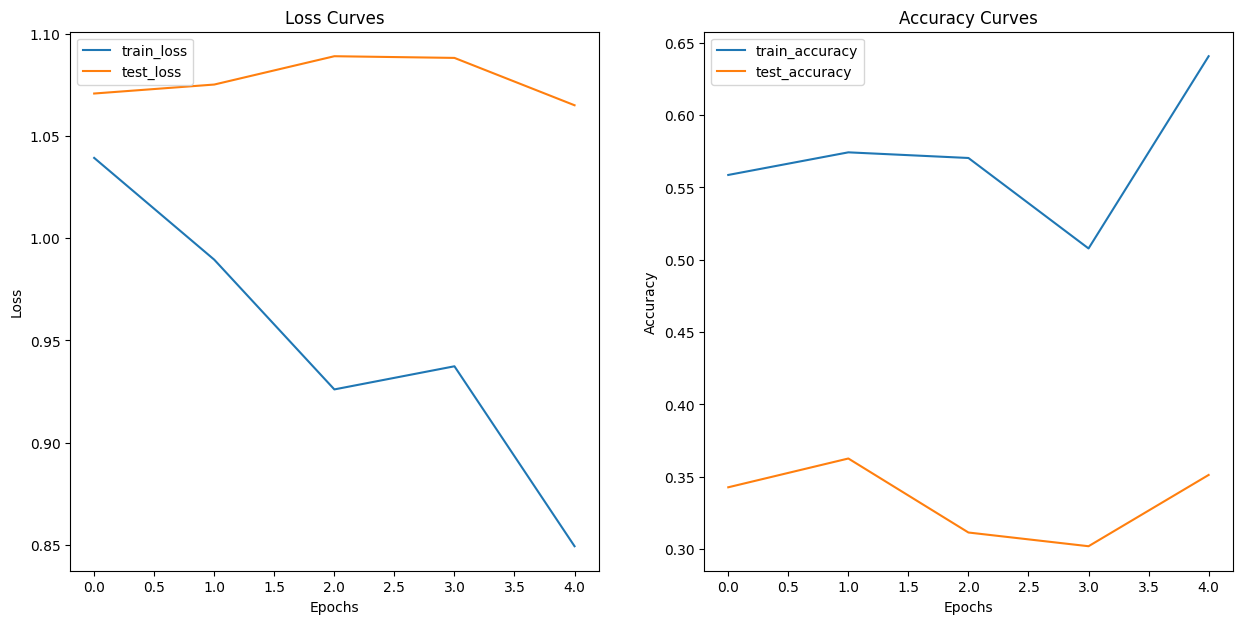

In [78]:
#call
plot_loss_curve(model_0_results)

### Model 1: TinyVGG with Data Augmentation

#### Training Transform with `TrivialaugmentWide`

In [79]:
from torchvision import transforms

#training transform
train_transform_trivial_aug = transforms.Compose([
    transforms.Resize(size= (64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

#testing transform
test_transform = transforms.Compose([
    transforms.Resize(size= (64,64)),
    transforms.ToTensor()
])

#### Dataset's and DataLoaders
- Images -> Dataset - using `torchvision.datasets.ImageFolder`
- -> Dataloader using `torch.utils.data.DataLoader()`

In [80]:
# images -> dataset
train_data_aug = datasets.ImageFolder(root=train_dir, transform= train_transform_trivial_aug)
test_data_simp = datasets.ImageFolder(root=test_dir, transform= test_transform)

train_data_aug, test_data_simp

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [81]:
# datasets -> dataloaders

import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_aug = DataLoader(train_data_aug,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle = True)

test_dataloader_simp = DataLoader(test_data_simp,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle = False)
train_dataloader_aug, test_dataloader_simp

(<torch.utils.data.dataloader.DataLoader at 0x78405f7b1a20>,
 <torch.utils.data.dataloader.DataLoader at 0x784060c137c0>)

#### Bulid and Train Model 1

In [82]:
train_data_aug.classes

['pizza', 'steak', 'sushi']

In [83]:
# model instance
torch.manual_seed(42)
model_1 = TinyVGG(input_shape= 3,
                  hidden_units=10,
                  output_shape=len(train_data_aug.classes)).to(device)
model_1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [84]:
# it's training time

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

# loss fn, optimizer, accuracy fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr = 0.001)

# timer
from timeit import default_timer as timer
start_time = timer()

# train
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_aug,
                        test_dataloader=test_dataloader_simp,
                        optimizer=optimizer,
                        loss_fn= loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1049 | Train acc: 0.2500 | Test Loss: 1.1019 | Test acc: 0.2604
Epoch: 1 | Train Loss: 1.0807 | Train acc: 0.4258 | Test Loss: 1.1261 | Test acc: 0.2604
Epoch: 2 | Train Loss: 1.0712 | Train acc: 0.4258 | Test Loss: 1.1592 | Test acc: 0.2604
Epoch: 3 | Train Loss: 1.1254 | Train acc: 0.3047 | Test Loss: 1.1581 | Test acc: 0.2604
Epoch: 4 | Train Loss: 1.0858 | Train acc: 0.4258 | Test Loss: 1.1551 | Test acc: 0.3333
Total Training Time: 5.056 seconds


#### plot loss curves for Model 1

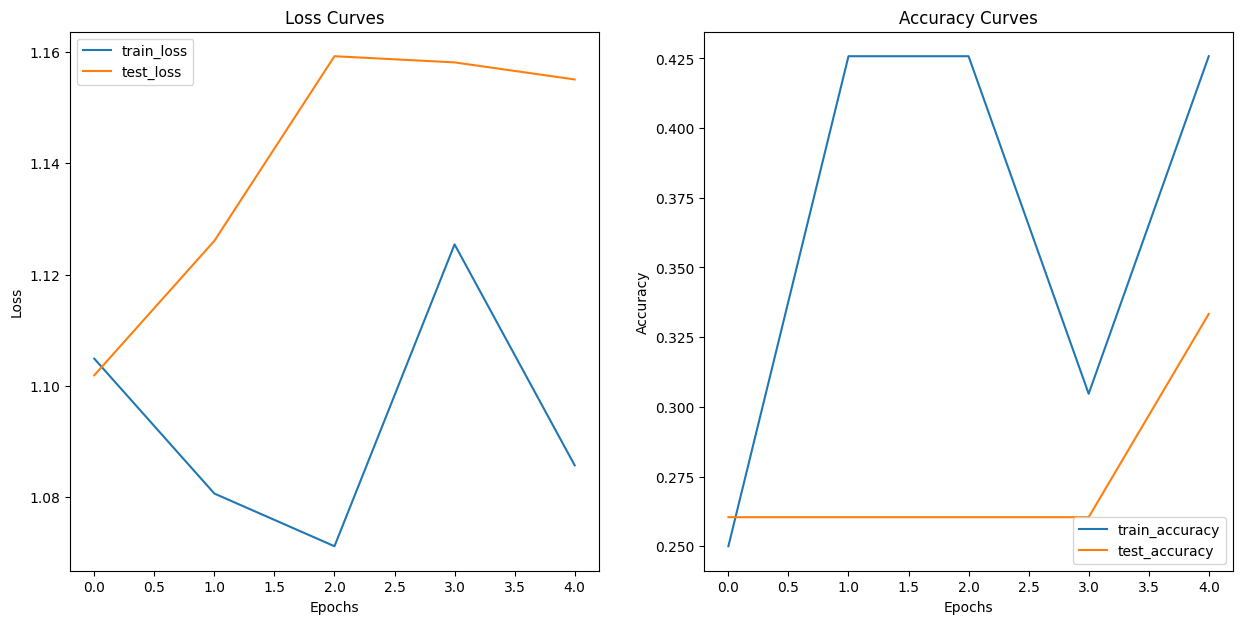

In [85]:
plot_loss_curve(model_1_results)

Here we see, our both models (`model_0` and `model_1`) performed equally poorly
many things can be done to improve model performance

- increasing number of layers
- utlizing different forms of data augmentation
- using a learning rate scheduler
- increasing the size of training dataset
- increase the number of epochs
- can use transfer learning
- use different form of regularization depending on whether our model is underfitting or overfitting
- increase the size of image on which we're training our model


### Prediction on a Custom Image(not from test set)

In [86]:
# download custom image
import requests

#setup path
custom_image_path = data_path/'pizza-image.jpeg'

# download if not already exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get("https://raw.githubusercontent.com/aashu-0/images/refs/heads/main/IMG_20230924_214608.jpg")
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists')

#### Converting our custom Image to same format as of training data
- to tensor form
- shape -> 64x64x3
- to.(device)

In [87]:
import torchvision

# reading the image
custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
print(f'Image tensor: \n{custom_image_unit8}')
print(f'Image shape: \n{custom_image_unit8.shape}')
print(f'Image Datatype: \n{custom_image_unit8.dtype}')

Image tensor: 
tensor([[[141, 143, 148,  ..., 150, 151, 151],
         [145, 146, 149,  ..., 150, 149, 150],
         [143, 144, 145,  ..., 148, 148, 150],
         ...,
         [107, 103, 103,  ..., 114, 107, 100],
         [107, 104, 102,  ..., 108, 101, 101],
         [104,  99,  98,  ...,  99,  96, 102]],

        [[131, 133, 135,  ..., 130, 131, 131],
         [135, 136, 136,  ..., 130, 129, 130],
         [135, 136, 135,  ..., 128, 128, 130],
         ...,
         [ 76,  72,  72,  ...,  91,  84,  77],
         [ 76,  73,  71,  ...,  86,  81,  81],
         [ 73,  68,  67,  ...,  79,  76,  84]],

        [[119, 121, 126,  ..., 121, 122, 122],
         [123, 124, 127,  ..., 121, 120, 121],
         [122, 123, 125,  ..., 119, 119, 121],
         ...,
         [107, 103, 103,  ..., 107, 100,  93],
         [107, 104, 102,  ...,  98,  93,  93],
         [104,  99,  98,  ...,  88,  88,  96]]], dtype=torch.uint8)
Image shape: 
torch.Size([3, 3072, 4080])
Image Datatype: 
torch.uint8


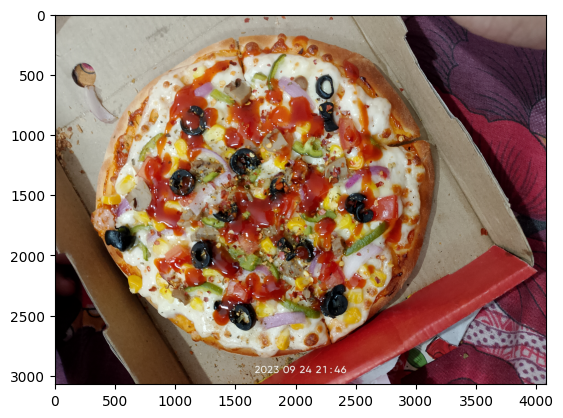

In [88]:
# plot using matplotlib
plt.imshow(custom_image_unit8.permute(1,2,0));

In [89]:
# ERROR -> different type of tensor
# making prediction with our trained model

model_1.eval()
with torch.inference_mode():
  model_1(custom_image_unit8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [90]:
# load the image and convert into torch.float32, which is compatible with our model

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image

tensor([[[0.5529, 0.5608, 0.5804,  ..., 0.5882, 0.5922, 0.5922],
         [0.5686, 0.5725, 0.5843,  ..., 0.5882, 0.5843, 0.5882],
         [0.5608, 0.5647, 0.5686,  ..., 0.5804, 0.5804, 0.5882],
         ...,
         [0.4196, 0.4039, 0.4039,  ..., 0.4471, 0.4196, 0.3922],
         [0.4196, 0.4078, 0.4000,  ..., 0.4235, 0.3961, 0.3961],
         [0.4078, 0.3882, 0.3843,  ..., 0.3882, 0.3765, 0.4000]],

        [[0.5137, 0.5216, 0.5294,  ..., 0.5098, 0.5137, 0.5137],
         [0.5294, 0.5333, 0.5333,  ..., 0.5098, 0.5059, 0.5098],
         [0.5294, 0.5333, 0.5294,  ..., 0.5020, 0.5020, 0.5098],
         ...,
         [0.2980, 0.2824, 0.2824,  ..., 0.3569, 0.3294, 0.3020],
         [0.2980, 0.2863, 0.2784,  ..., 0.3373, 0.3176, 0.3176],
         [0.2863, 0.2667, 0.2627,  ..., 0.3098, 0.2980, 0.3294]],

        [[0.4667, 0.4745, 0.4941,  ..., 0.4745, 0.4784, 0.4784],
         [0.4824, 0.4863, 0.4980,  ..., 0.4745, 0.4706, 0.4745],
         [0.4784, 0.4824, 0.4902,  ..., 0.4667, 0.4667, 0.

In [91]:
# ERROR -> shapes are not aligned with the model
# making prediction with our trained model

model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x778005 and 1690x3)

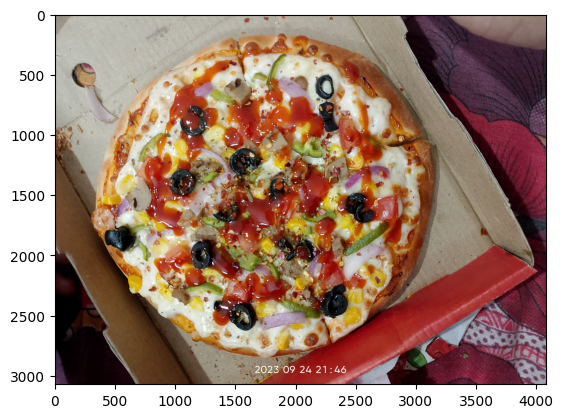

In [92]:
# plot using matplotlib
plt.imshow(custom_image.permute(1,2,0));

In [93]:
# transform pipeline to resize image
from torchvision import transforms

custom_img_transform = transforms.Compose([transforms.Resize(size=(64,64))])

# transform the image
custom_img_transformed = custom_img_transform(custom_image)
print(f'Original Image Shape: {custom_image.shape}')
print(f'Transformed image shape: {custom_img_transformed.shape}')

Original Image Shape: torch.Size([3, 3072, 4080])
Transformed image shape: torch.Size([3, 64, 64])


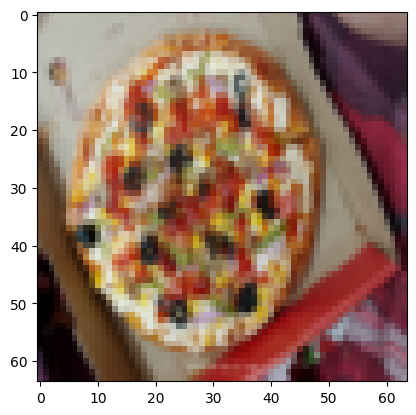

In [94]:
# plot using matplotlib
plt.imshow(custom_img_transformed.permute(1,2,0));

In [95]:
#ERROR -> no batch size added to image
# making prediction with our trained model

model_1.eval()
with torch.inference_mode():
  model_1(custom_img_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [96]:
# adding batch_size dimension to the custom image

custom_img_transformed.shape, custom_img_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [97]:
custom_img_final = custom_img_transformed.unsqueeze(0)

model_1.eval()
with torch.inference_mode():
  custom_img_pred = model_1(custom_img_final.to(device))

custom_img_pred

tensor([[ 0.0716,  0.0428, -0.2017]], device='cuda:0')

In [98]:
class_names

['pizza', 'steak', 'sushi']

In [99]:
# convert logits -> predictions probability
custom_img_pred_probs = torch.softmax(custom_img_pred, dim=1)
custom_img_pred_probs

tensor([[0.3660, 0.3556, 0.2784]], device='cuda:0')

In [100]:
# prediction probabilities -> prediction labels
custom_img_pred_label = torch.argmax(custom_img_pred_probs, dim=1).cpu()
custom_img_pred_label

tensor([0])

In [101]:
class_names[custom_img_pred_label]

'pizza'

### Buliding a function to make prediction on custom image

In [102]:
def pred_plot_img(model: torch.nn.Module,
                  image_path: str,
                  class_names: List[str],
                  transform: None,
                  device: torch.device = device):
  # load the image
  target_img = torchvision.io.read_image(str(image_path)).type(torch.float32)/255

  # transform
  if transform:
    target_img = transform(target_img)

  # to device
  model.to(device)

  # evaluation mode
  model.eval()
  with torch.inference_mode():
    # add extra dim
    target_img = target_img.unsqueeze(dim=0)

    # make preds
    target_img_pred = model(target_img.to(device))

  # logits -> probab
  target_img_pred_probs = torch.softmax(target_img_pred, dim=1)

  # probab -> preds labels
  target_img_pred_label = torch.argmax(target_img_pred_probs, dim=1)

  # plot the image and preds prob
  plt.imshow(target_img.squeeze().permute(1,2,0))

  if class_names:
    title = f"Pred :{class_names[target_img_pred_label.cpu()]} Prob: {target_img_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_img_pred_label} | Prob: {target_img_pred_probs.max().cpu():.3f}"

  plt.title(title)
  plt.axis(False)

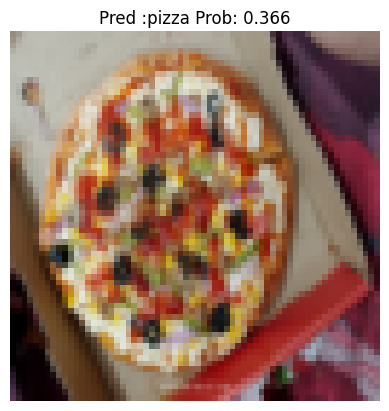

In [103]:
# let's try on our custom image
pred_plot_img(model=model_1,
              image_path=custom_image_path,
              class_names=class_names,
              transform=custom_img_transform,
              device = device)